In [1]:
import oolearning as oo
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [82]:
csv_file = 'titanic_data.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [83]:
explore.dataset.head()  # we can access the data directly by `.dataset`

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
# Description of data says (https://www.kaggle.com/c/titanic/data):
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# let's convert Pclass to categoric variable
#explore.set_as_categoric(feature='Pclass', mapping={1: 'Upper', 2: 'Middle', 3: 'Lower'})

In [85]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
PassengerId,891,0,0.000,0,0.000,446.000,257.354,0.577,0.000,-1.200,1.00,90.00,223.500,446.000,668.5,802.000,891.000
Pclass,891,0,0.000,0,0.000,2.309,0.836,0.362,-0.631,-1.280,1.00,1.00,2.000,3.000,3.0,3.000,3.000
Age,714,177,0.199,0,0.000,29.699,14.526,0.489,0.389,0.178,0.42,14.00,20.125,28.000,38.0,50.000,80.000
SibSp,891,0,0.000,608,0.682,0.523,1.103,2.108,3.695,17.880,0.00,0.00,0.000,0.000,1.0,1.000,8.000
Parch,891,0,0.000,678,0.761,0.382,0.806,2.112,2.749,9.778,0.00,0.00,0.000,0.000,0.0,2.000,6.000
Fare,891,0,0.000,15,0.017,32.204,49.693,1.543,4.787,33.398,0.00,7.55,7.910,14.454,31.0,77.958,512.329


In [6]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
Pclass,891,0,0.000,Lower,3,0.003
Name,891,0,0.000,"van Melkebeke, Mr. Philemon",891,1.000
Sex,891,0,0.000,male,2,0.002
Ticket,891,0,0.000,CA. 2343,681,0.764
Cabin,204,687,0.771,B96 B98,147,0.721
Embarked,889,2,0.002,S,3,0.003
Survived,891,0,0.000,died,2,0.002


In [8]:
splitter = oo.ClassificationStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, _ = splitter.split(target_values=explore.dataset.Survived)  # ignore holdout indexes

In [9]:
training_y = explore.dataset.iloc[training_indexes][target_variable]
training_x = explore.dataset.iloc[training_indexes].drop(columns=target_variable)
training_x.shape

(712, 11)

In [111]:
training_x.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,29.807687,0.492978,0.390449,31.819826
std,257.465527,14.485211,1.060720,0.838134,48.059104
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,39.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
len(_)

179

In [11]:
training_y.value_counts(normalize=True)

died     0.616573
lived    0.383427
Name: Survived, dtype: float64

## Find Best Hyper-Params via Tuner

Now, let's use a **`ModelTuner`** object to search for the best hyper-parameters for a given model, by evaluating various hyper-parameter combinations. 

In [18]:
# define the transformations
transformations = [oo.RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   #oo.CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   oo.ImputationTransformer(),
                   oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

# define the scores, which will be used to compare the performance across hyper-param combinations
# the scores need a Converter, which contains the logic necessary to convert the predicted values to a predicted class.
score_list = [oo.AccuracyScore(converter=oo.TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=oo.CartDecisionTreeClassifier(),  # using a Random Forest model
                                             transformations=transformations,
                                             scores=score_list,
                                             folds=5,
                                             repeats=5,
                                             fold_decorators=[oo.TwoClassThresholdDecorator(parallelization_cores=0)])

# NOTE: we need to turn off parallelization for `TwoClassThresholdDecorator`
# (i.e. `parallelization_cores=0`) since we are using parallelization with `ModelTuner`

# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                   hyper_param_object=oo.CartDecisionTreeHP(criterion='gini'),
                   parallelization_cores=-1)  # Hyper-Parameter object specific to RF

In [22]:
# get the expected columns at the time we do the training, based on the transformations 
columns = oo.TransformerPipeline.get_expected_columns(transformations=transformations, data=training_x)

# define the combinations of hyper-params that we want to evaluate
params_dict = dict(max_depth=[4, 6, 8],
                   min_samples_leaf=[4, 6, 8],
                   min_samples_split=[5, 10, 15]
                  )
grid = oo.HyperParamsGrid(params_dict=params_dict)

We'll pass the **`HyperParamsGrid`** object to the tuner, which will tell the tuner which combinations of hyper-params to try. We can preview the combinations with **`.params_grid()`**

In [23]:
grid.params_grid

,max_depth,min_samples_leaf,min_samples_split
0,4,4,5
1,4,4,10
2,4,4,15
3,4,6,5
4,4,6,10
5,4,6,15
6,4,8,5
7,4,8,10
8,4,8,15
9,6,4,5


In [24]:
tuner.tune(data_x=training_x, data_y=training_y, params_grid=grid)

## Evaluate

We can see the raw results of the `ModelTuner` via **`tuner.results.resampled_stats`**.

Each hyper-parameter combination that was evaluated is represented by a row, with the columns either representing a particular hyper-parameter, or a Score's statistic (e.g. mean, standard deviation, or coefficient of variation). 

Each Score will be represented with three columns: the **mean** of the resampled Score values (i.e. the mean of the 25 Score values associated with each fold/repeat of the Resampler), the **standard deviation** of the resampled Score values, and the **coefficient of variation** of the values.

In [26]:
tuner.results.resampled_stats

,max_depth,min_samples_leaf,min_samples_split,accuracy_mean,accuracy_st_dev,accuracy_cv
0,4,4,5,0.809698,0.029445,0.04
1,4,4,10,0.808929,0.029963,0.04
2,4,4,15,0.810308,0.030671,0.04
3,4,6,5,0.811769,0.029486,0.04
4,4,6,10,0.811769,0.029486,0.04
5,4,6,15,0.811506,0.029661,0.04
6,4,8,5,0.811800,0.029211,0.04
7,4,8,10,0.811800,0.029211,0.04
8,4,8,15,0.811800,0.029211,0.04
9,6,4,5,0.805468,0.033173,0.04


We can interpret the results easier by visualizing with a heatmap, below.

The hyper-parameter combination that is considered the "best" has a red label on the y-axis. The "best" combination is the one that has the "best" Score (i.e. the Scores that were passed into the Tuner during object creation). If multiple Score objects were passed in, then the first in the list is used (in this case, the first Score we specified above was `AucRocScore`).

Remember, a Score can either be associated with a **utility** function or a **cost** function. A `utility` function (e.g. `AUC`) has score values where higher values represent a better score. A `cost` function (e.g. `error rate`) has score values where lower values represent a better score. This is represented in the heatmap with green (for `utility`) and blue (for `cost`) colors. In both cases, darker colors represent "better" scores. So in the case of `AUC`, higher numbers are better, and associated with darker colors. In the case of `error rate`, lower numbers are better and are also associated with darker numbers. The columns representing `standard deviation` (`SD`) and `coefficient of variation` (`CV`) always have darker colors associated lower numbers, because lower `SD`s and `CV`s represent more consistent results, which is better.

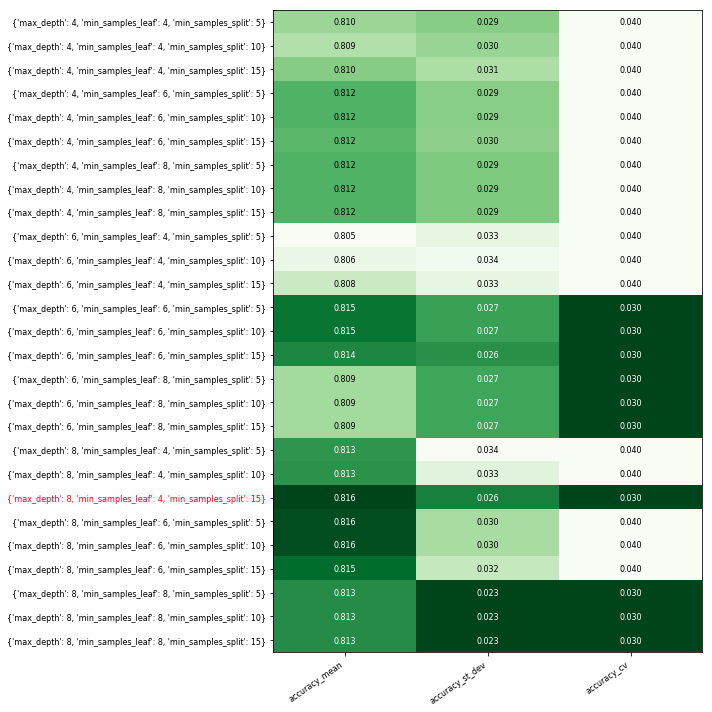

In [27]:
tuner.results.plot_resampled_stats()

In addition to the heatmap, we can also visualize the Resampled score values for a specific metric.

For example, each boxplot below represents the 25 (i.e. 5 fold, 5 repeats) AUC values associated with each of the hyper-parameter combinations that were evaluated.

In [ ]:
tuner.results.plot_resampled_scores(metric=Metric.AUC_ROC)

In addition to the results, we can also access how long it took to resample (5 folds, 5 repeats) each of the combinations.

In [ ]:
tuner.results.resampler_times

We can also get the metrics associated with the "best" combination. 

As explained above, the hyper-parameter combination that is considered the "best" is the one that has the "best" Score object that was passed into the Tuner. If multiple Score objects were passed in, then the first in the list is used (in this case, the first Score we specified above was `AucRocScore`).

In [ ]:
tuner.results.best_model

And to get the parameter names/values in dictionary format, we can use **`tuner.results.best_hyper_params`**

In [ ]:
tuner.results.best_hyper_params

Frequently, though, the first time we search across various (sometimes random) hyper-parameters combinations, we will not find the best **possible** combination, since we are evaluating a tiny fraction of all possible combinations. For a given parameter, the ideal value might be above or below the range of values that we tried. Or, our range might have been too wide, and we need to "zoom in" and try more granular values when we have more information about the general vicinity of the ideal value.

**`tuner.results.plot_hyper_params_profile()`** helps us gain a better understanding of the performance of the various parameter values that we tried. We can visualize the performance of a specific hyper-parameter, or a set of hyper-paremeters (and there relationship to eachother).

In [ ]:
tuner.results.plot_hyper_params_profile(metric=Metric.AUC_ROC,
                                        x_axis='max_features',
                                        line='n_estimators',
                                        grid='min_samples_leaf')

In [ ]:
tuner.results.plot_hyper_params_profile(metric=Metric.AUC_ROC, x_axis='max_features')

Finally, we utilized the a Decorator object when we defined the `RepeatedCrossValidationResampler` (via this line of code: **`fold_decorators=[TwoClassThresholdDecorator()]`**); that object piggy-backed off of the Resampler (for each hyper-parameter combination), and captured information about the "ideal threshold" for each combination. 

Remember, the values that we get back from our predictions will be continuous values (e.g. probabilities), and we have to convert those probabilities to classes. The standard way of doing this is that any predicted value (associated with the 'positive class' for a two-class problem) that is greater than `0.5` will be converted to the `positive` class, otherwise to the `negative`. If we want better insight into alternative thresholds, we can use the `Decorator` object (which, for each fold/repeat, calculates the threshold closest to the upper left corner of the `ROC` curve and upper right corner of the `precision-recall` curve).

In [ ]:
# best_index is the associated with the best model's hyper-parameters
best_decorator = tuner.results.resampler_decorators_first[tuner.results.best_index]
calculated_resampled_threshold = best_decorator.roc_ideal_thresholds_mean
calculated_resampled_threshold

# Retrain & Evaluate

## Set Up `ModelTrainer`

After finding the best hyper-parameters, we want to retrain the model with those parameters on the full training set and predict/evaluate on the holdout set.

As stated previously, since we'll use same type of `Splitter` in the `ModelTrainer`, the training/holdout split will be the same (i.e. same training indexes/data used in the Tuner from the manual split will be used to refit the final model).

Note, instead of using the default threshold of `0.5`, we'll use the threshold calculated by the Decorator via the resampler (associated with the hyper-parameters we are choosing), that makes the best tradeoff between Sensitivity/Specificity, captured via **`calculated_resampled_threshold`**.

In [100]:
# define how we want to split the training/holding datasets
splitter = oo.ClassificationStratifiedDataSplitter(holdout_ratio=0.2)

# define the transformations
transformations = [oo.RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
#                   oo.CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   oo.ImputationTransformer(),
                   oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

# Define how we want to evaluate (and convert the probabilities DataFrame to predicted classes)
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                                         oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class='lived'))

# give the objects, which encapsulate the behavior of everything involved with training the model, to our ModelTrainer
trainer = oo.ModelTrainer(model=oo.CartDecisionTreeClassifier(random_state=None),
                       model_transformations=transformations,
                       splitter=splitter,
                       evaluator=evaluator)

## Set Up Hyper-Parameters

Let's define the hyper-parameters we want to use.

We know we want to use the **`RandomForestHP`** class, which contains the specific parameters available to train with, but we also know that for some of those, we'll want to update them with the values we found with our `ModelTuner`.

Let's first define our object, and use **`.params_dict`** to see the default hyper-parameters and values.

In [101]:
rf_hyper_params = oo.CartDecisionTreeHP(criterion='gini')
rf_hyper_params.params_dict

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_leaf_nodes': None,
 'max_features': None}

In [102]:
tuner.results.best_hyper_params

{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 15}

Now let's update the specific parameters that we found with the `ModelTuner` (which we can access via **`tuner.results.best_hyper_params`**).

We can use **`.update_dict()`**, which conveniently takes a dictionary with the parameter names/values that we want to update (which is what `best_hyper_params` returns) and updates the corresponding values of the hyper-parameters within our object.

In this case, the only parameter that will actually change is `max_features`; the other parameters have values that are the same as the defaults.

In [103]:
#rf_hyper_params.update_dict(tuner.results.best_hyper_params)
rf_hyper_params.update_dict({'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 10})
rf_hyper_params.params_dict

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 6,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'min_weight_fraction_leaf': 0.0,
 'max_leaf_nodes': None,
 'max_features': None}

## Train & Evaluate

In [104]:
trainer.train(data=explore.dataset, target_variable='Survived', hyper_params=rf_hyper_params)

In [106]:
trainer.model.data_x_trained_head

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
692,3,28.5,0,0,56.4958,0,1,0,0,1
481,2,28.5,0,0,0.0000,0,1,0,0,1
527,1,28.5,0,0,221.7792,0,1,0,0,1
855,3,18.0,0,1,9.3500,1,0,0,0,1
801,2,31.0,1,1,26.2500,1,0,0,0,1
652,3,21.0,0,0,8.4333,0,1,0,0,1
509,3,26.0,0,0,56.4958,0,1,0,0,1
557,1,28.5,0,0,227.5250,0,1,1,0,0
828,3,28.5,0,0,7.7500,0,1,0,1,0
18,3,31.0,1,0,18.0000,1,0,0,0,1


In [110]:
trainer.model.model_object

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [107]:
# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9145243518819828,
 'AUC Precision/Recall': 0.8840270943160664,
 'Kappa': 0.7091453241369821,
 'F1 Score': 0.8111332007952287,
 'Two-Class Accuracy': 0.8665730337078652,
 'Error Rate': 0.13342696629213482,
 'True Positive Rate': 0.7472527472527473,
 'True Negative Rate': 0.9407744874715261,
 'False Positive Rate': 0.05922551252847381,
 'False Negative Rate': 0.25274725274725274,
 'Positive Predictive Value': 0.8869565217391304,
 'Negative Predictive Value': 0.8568464730290456,
 'Prevalence': 0.38342696629213485,
 'No Information Rate': 0.6165730337078652,
 'Total Observations': 712}

In [108]:
# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.all_quality_metrics

{'AUC ROC': 0.7949934123847168,
 'AUC Precision/Recall': 0.7389443087292714,
 'Kappa': 0.507022858716607,
 'F1 Score': 0.6721311475409837,
 'Two-Class Accuracy': 0.776536312849162,
 'Error Rate': 0.22346368715083798,
 'True Positive Rate': 0.5942028985507246,
 'True Negative Rate': 0.8909090909090909,
 'False Positive Rate': 0.10909090909090909,
 'False Negative Rate': 0.4057971014492754,
 'Positive Predictive Value': 0.7735849056603774,
 'Negative Predictive Value': 0.7777777777777778,
 'Prevalence': 0.3854748603351955,
 'No Information Rate': 0.6145251396648045,
 'Total Observations': 179}

In [49]:
# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.plot_all_quality_metrics()

AttributeError: 'NoneType' object has no attribute 'plot_all_quality_metrics'

Again, the `True Positive Rate`, `True Negative Rate`, etc., above is affected by the point on the ROC curve that we used to convert the continuous predictions to `lived` or `died`. We used a threshold of:

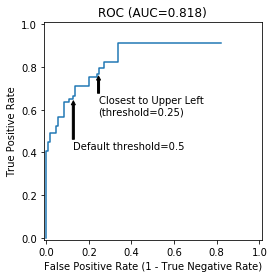

In [39]:
trainer.holdout_evaluator.plot_roc_curve()

The value we used looks to be close to the defualt, but also a little closer to the upper left point on the ROC curve associated with the holdout set.

Now, what about the Precision/Recall curve?

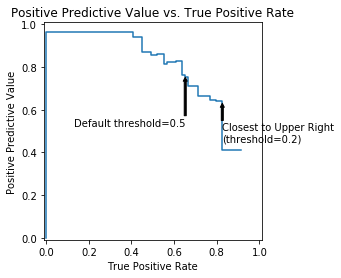

In [43]:
trainer.holdout_evaluator.plot_ppv_tpr_curve()

In the case of the precision recall curve, the value we chose seems to be in the opposite direction of the upper right point of the curve, relative to the default. Perhaps our potential gain in balancing the sensitivity/specificity tradeoff resulted in sacrificing some of the balance of the precision/recall trade-off.

Note: the threshold used in the Score to evaluate the performances was 0.5, rather than using the decorators that find the "ideal" threshold. IMO, in general, it is better to use metrics like AUC that don't depend on the ROC (or Precision-Recall) tradeoffs when searching across models/hyper-parameters, and then once the best model/hyper-parameter is found based on AUC, determine how you want to make tradeoffs based on your particular situation/problem. Of course, if some particular errors are much more important than other errors, this might not be the best approach.

In [114]:
kaggle_test_file = 'test.csv'
kaggle_test_set = pd.read_csv(kaggle_test_file)
trainer.predict(kaggle_test_set)
kaggle_predictions = [1 if x > 0.5 else 0 for x in trainer.predict(kaggle_test_set)['lived']]

In [113]:
 trainer.predict(kaggle_test_set)

,died,lived
0,0.876866,0.123134
1,0.666667,0.333333
2,0.876866,0.123134
3,0.876866,0.123134
4,0.375000,0.625000
5,0.876866,0.123134
6,0.125000,0.875000
7,0.975610,0.024390
8,0.125000,0.875000
9,0.975610,0.024390


In [112]:
test_set_predictions = pd.DataFrame({'PassengerId': kaggle_test_set['PassengerId'], 'Survived': kaggle_predictions})
test_set_predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [81]:
test_set_predictions.to_csv('test_predictions_custom.csv', index=False)